In [1]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)

### Set file names
outFilePath='../data/proc/'

### Truth file settings
truthFileName='../data/proc/truth.nc'

### Other run settings
runningLocation = 'gdata'
if  runningLocation== 'local':
    hisFilePath='../data/raw/'
elif runningLocation == 'gdata':
    hisFilePath='/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/'
prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'

loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [2]:
def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

In [3]:
### Open truth file
truthIn = xr.open_dataset(truthFileName) 

truth = dropDuplicateTimes(truthIn)

In [4]:
### load other run

chunks = {'ocean_time':1}
filelist = glob.glob(hisFilePath+prefixAnalysis+'08*.nc')

def preprocessRemoveLastDay(ds):
    '''remove the last 7 timesteps from each file'''
    return ds.isel(ocean_time = slice(0,-7))

for files in filelist: 
    print(files)
    # filelist.append(files)
osse = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal',compat='override',coords='minimal',parallel=True, join='right') 

/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/roms_fwd_outer1_08093.nc
/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/roms_fwd_outer1_08125.nc
/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/roms_fwd_outer1_08149.nc
/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/roms_fwd_outer1_08057.nc
/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/roms_fwd_outer1_08157.nc
/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/roms_fwd_outer1_08273.nc
/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/roms_fwd_outer1_08161.nc
/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/roms_fwd_outer1_08229.nc
/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/roms_fwd_outer1_08053.nc
/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/roms_fwd_outer1_08253.nc
/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/roms_fwd_outer1_08045.nc
/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/roms_fwd_outer1_08017.nc
/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/roms_fwd_outer1_08265.nc
/g/data/fu5/deg581/EAC_2yr_OSSE_SSHSST/output/roms_fwd_outer1_08261.nc
/g/dat

In [5]:
truth

<xarray.Dataset>
Dimensions:     (eta_rho: 317, eta_u: 317, eta_v: 316, ocean_time: 193, s_rho: 30, xi_rho: 272, xi_u: 271, xi_v: 272)
Coordinates:
    lon_rho     (eta_rho, xi_rho) float64 ...
    lat_rho     (eta_rho, xi_rho) float64 ...
  * ocean_time  (ocean_time) datetime64[ns] 2011-11-28T12:00:00 ... 2014-01-0...
  * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
    lon_u       (eta_u, xi_u) float64 ...
    lat_u       (eta_u, xi_u) float64 ...
    lon_v       (eta_v, xi_v) float64 ...
    lat_v       (eta_v, xi_v) float64 ...
Dimensions without coordinates: eta_rho, eta_u, eta_v, xi_rho, xi_u, xi_v
Data variables:
    zeta        (ocean_time, eta_rho, xi_rho) float32 ...
    sst         (ocean_time, eta_rho, xi_rho) float32 ...
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    u           (ocean_time, s_rho, eta_u, xi_u) float32 ...
    v           (ocean_time, s_rho, eta_v, xi_v) float32 ...

In [6]:
osse

<xarray.Dataset>
Dimensions:        (IorJ: 317, Nstate: 11, boundary: 4, eta_psi: 316, eta_rho: 317, eta_u: 317, eta_v: 316, obc_adjust: 11, ocean_time: 1656, s_rho: 30, s_w: 31, tracer: 2, xi_psi: 271, xi_rho: 272, xi_u: 271, xi_v: 272)
Coordinates:
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lat_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lon_u          (eta_u, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
    lat_u          (eta_u, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
    lon_v          (eta_v, xi_v) float64 dask.array<chunksize=(316, 272), meta=np.ndarray>
    lat_v          (eta_v, xi_v) float64 dask.array<chunksize=(316, 272), meta=np.ndarray>
    lon_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(316, 271), meta=np.ndarray>
    lat_psi        (eta_psi, xi_psi) float64 dask.array<chunksize=(316, 271), meta=np.ndarray>
  * ocean_time     (ocean_time) datetime64[ns] 2011-12-02 ... 2012-09-02T20:0...
Dimensions without coordinates: IorJ, Nstate, boundary, eta_psi, eta_rho, eta_u, eta_v, obc_adjust, tracer, xi_psi, xi_rho, xi_u, xi_v
Data variables: (12/132)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    shflux         (ocean_time, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 317, 272), meta=np.ndarray>
    ssflux         (ocean_time, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 317, 272), meta=np.ndarray>
    Tair           (ocean_time, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 317, 272), meta=np.ndarray>
    EminusP        (ocean_time, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 317, 272), meta=np.ndarray>
    sustr          (ocean_time, eta_u, xi_u) float64 dask.array<chunksize=(1, 317, 271), meta=np.ndarray>
    svstr          (ocean_time, eta_v, xi_v) float64 dask.array<chunksize=(1, 316, 272), meta=np.ndarray>
Attributes: (12/39)
    file:              roms_fwd_outer1.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Friday - June 4, 2021 -  2:19:...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ADJOINT, ADJUST_BOUNDARY, ADJUST_STFLUX, ADJUST_W...

In [7]:
def calc_rmseSpatial(input1,input2,iRange,jRange):
    err2 = (input1-input2)**2
    err=err2**(1/2)
    output = indexMeanMetric(err,iRange,jRange)
    return err,output

# define function for calculating spatial mean
def indexMeanMetric(input,iRange,jRange):
    iRange=range(iRange[0],iRange[1]+1)
    jRange=range(jRange[0],jRange[1]+1)
    output = input.isel(eta_rho=iRange, xi_rho=jRange).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

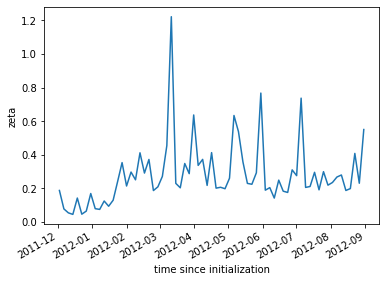

In [8]:
iRangeMetric = [115, 200]
jRangeMetric = [85, 150]


err,ssh_rmse_metrics = calc_rmseSpatial(osse.zeta,truth.zeta,iRangeMetric,jRangeMetric)

ssh_rmse_metrics.plot()